<a href="https://colab.research.google.com/github/hannasorolee/toronto-airbnb-price-predictor/blob/main/capstone_code_hanna_lee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

# Load Google Sheets as CSV
toronto_csv_url = (
    "https://docs.google.com/spreadsheets/d/"
    "18DbatkTWogKwESjq4Hpe2pfvHOfto3DsnZwbu6o7cMM"
    "/export?format=csv&gid=1174158840"
)
tor = pd.read_csv(toronto_csv_url)


# Define core columns
core_columns = [
    "id", "name", "description","neighborhood_overview",
    "neighbourhood_cleansed","room_type", "accommodates", "bedrooms",
    "bathrooms", "price", "minimum_nights", "host_is_superhost",
    "number_of_reviews", "review_scores_rating", "reviews_per_month"
]

tor = tor[core_columns]

# Preview top 10 rows
print("Top 10 sample rows:\n")
display(tor.head(10))


# Generate describe and null/unique table
describe_df = tor.describe(include='all').transpose()


# Add nulls and unique values
describe_df['nulls'] = tor.isna().sum()
describe_df['unique'] = tor.nunique()


# Reorder columns for clarity
summary = describe_df[['count', 'unique', 'nulls', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
print("Summary Statistics for Core Columns:\n")
display(summary)


Top 10 sample rows:



,id,name,description,neighborhood_overview,neighbourhood_cleansed,room_type,accommodates,bedrooms,bathrooms,price,minimum_nights,host_is_superhost,number_of_reviews,review_scores_rating,reviews_per_month
0,1419.0,Beautiful home in amazing area!,"This large, family home is located in one of T...",The apartment is located in the Ossington stri...,Little Portugal,Entire home/apt,10,5.0,NaN,NaN,28,f,6,5.00,0.05
1,8077.0,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,NaN,Waterfront Communities-The Island,Private room,2,NaN,NaN,NaN,180,f,169,4.84,0.88
2,26654.0,"World Class @ CN Tower, convention centre, The...","CN Tower, TIFF Bell Lightbox, Metro Convention...",There's a reason they call it the Entertainmen...,Waterfront Communities-The Island,Entire home/apt,4,2.0,1.0,$158.00,28,t,45,4.80,0.26
3,27423.0,Executive Studio Unit- Ideal for One Person,"Brand new, fully furnished studio basement apa...",NaN,South Riverdale,Entire home/apt,1,NaN,NaN,NaN,365,f,32,4.94,0.17
4,30931.0,Downtown Toronto - Waterview Condo,Split level waterfront condo with a breathtaki...,NaN,Waterfront Communities-The Island,Entire home/apt,2,1.0,NaN,NaN,180,f,1,5.00,0.01
5,40456.0,Downtown- King Size Bed and Parking,---------------------Renovated and Newly Furn...,This is Nice Neighborhood located in Downtown ...,South Parkdale,Entire home/apt,5,2.0,NaN,NaN,750,t,113,4.64,0.62
6,43964.0,Cozy & Private Basement Apartment free parking,Cozy 2-Bedroom Basement Suite in Wexford-Maryv...,- Super quiet family-friendly neighborhood<br ...,Wexford/Maryvale,Entire home/apt,4,2.0,0.0,$143.00,2,f,67,4.96,0.65
7,44452.0,Yonge & Bloor Studio Skyline,NaN,NaN,Rosedale-Moore Park,Entire home/apt,2,1.0,1.0,$94.00,28,f,67,4.18,0.37
8,45399.0,Fountain View Studio - Eaton center,"Open Space studio style, Big windows, calm & r...","Amazing neighbourhood, very central and walkin...",Bay Street Corridor,Entire home/apt,3,0.0,1.0,$120.00,28,f,89,4.17,0.50
9,45893.0,Yonge & Bloor Lakeview Master BR,NaN,NaN,Rosedale-Moore Park,Private room,1,1.0,1.0,$69.00,28,f,24,4.40,0.13


Summary Statistics for Core Columns:



,count,unique,nulls,mean,std,min,25%,50%,75%,max
id,21092.0,21092,0,645421235516480000.0,554624590881750272.0,1419.0,34091273.5,798838175312913408.0,1165362628563508480.0,1438745508220814592.0
name,21092,20469,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,20686,18365,406,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighborhood_overview,9588,8025,11504,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighbourhood_cleansed,21092,140,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
room_type,21092,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accommodates,21092.0,16,0,3.188697,2.022056,1.0,2.0,2.0,4.0,16.0
bedrooms,19342.0,13,1750,1.500982,0.990192,0.0,1.0,1.0,2.0,50.0
bathrooms,15359.0,16,5733,1.287551,0.623595,0.0,1.0,1.0,1.5,20.0
price,15365,785,5727,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

#  Load Google Sheets as CSV
toronto_csv_url = (
    "https://docs.google.com/spreadsheets/d/"
    "18DbatkTWogKwESjq4Hpe2pfvHOfto3DsnZwbu6o7cMM"
    "/export?format=csv&gid=1174158840"
)
tor = pd.read_csv(toronto_csv_url)


# Define core columns
core_columns = [
    "id", "name", "description","neighborhood_overview",
    "neighbourhood_cleansed","room_type", "accommodates", "bedrooms",
    "bathrooms", "price", "minimum_nights", "host_is_superhost",
    "number_of_reviews", "review_scores_rating", "reviews_per_month"
]

tor = tor[core_columns]

#Clean 'price'
tor["price"] = tor["price"].replace('[\$,]', '', regex=True).astype(float)

#Filter only 1-bedroom
tor_1bd = tor[tor["bedrooms"].fillna(0) == 1].copy()

#change superhost t and f to 1 and 0
tor_1bd['host_is_superhost'] = tor_1bd['host_is_superhost'].map({'t': 1, 'f': 0})
tor_1bd['host_is_superhost'] = tor_1bd['host_is_superhost'].fillna(0).astype(int)


# Preview top 10 rows
print("Top 10 sample rows:\n")
display(tor_1bd.head(10))


# Generate describe and null/unique table
describe_df = tor_1bd.describe(include='all').transpose()


# Add nulls and unique values
describe_df['nulls'] = tor_1bd.isna().sum()
describe_df['unique'] = tor_1bd.nunique()


# Reorder columns for clarity
summary = describe_df[['count', 'unique', 'nulls', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
print("Summary Statistics for Core Columns:\n")
display(summary)


Top 10 sample rows:



,id,name,description,neighborhood_overview,neighbourhood_cleansed,room_type,accommodates,bedrooms,bathrooms,price,minimum_nights,host_is_superhost,number_of_reviews,review_scores_rating,reviews_per_month
4,30931.0,Downtown Toronto - Waterview Condo,Split level waterfront condo with a breathtaki...,NaN,Waterfront Communities-The Island,Entire home/apt,2,1.0,NaN,NaN,180,0,1,5.00,0.01
7,44452.0,Yonge & Bloor Studio Skyline,NaN,NaN,Rosedale-Moore Park,Entire home/apt,2,1.0,1.0,94.0,28,0,67,4.18,0.37
9,45893.0,Yonge & Bloor Lakeview Master BR,NaN,NaN,Rosedale-Moore Park,Private room,1,1.0,1.0,69.0,28,0,24,4.40,0.13
10,50110.0,Yorkville one bedroom Condo,Offering a great experience for guests staying...,The neighbourhood is one of most authentic and...,Church-Yonge Corridor,Entire home/apt,3,1.0,1.0,144.0,28,0,61,4.63,0.34
11,51616.0,Large room in trendy King Street West.,My place is near the trendy King St. West stri...,Near the hopping King st west strip of restaur...,Niagara,Private room,2,1.0,NaN,NaN,91,0,24,4.88,0.22
12,62545.0,Furnished Heritage Rooms Downtown 1,Our lovingly restored Classic Victorian Guest-...,NaN,Niagara,Private room,1,1.0,1.0,50.0,150,1,23,4.85,0.13
13,64635.0,Furnished Heritage Rooms Downtown 2,Our lovingly restored Classic Victorian Guest-...,NaN,Niagara,Private room,1,1.0,0.5,50.0,150,1,18,4.61,0.11
14,64641.0,Furnished Heritage Rooms Downtown 3,Our lovingly restored Classic Victorian Guest-...,NaN,Niagara,Private room,1,1.0,0.5,49.0,120,1,26,4.80,0.15
15,64645.0,Furnished Downtown Suite with Private Washroom,NaN,NaN,Niagara,Private room,1,1.0,1.0,60.0,120,1,16,4.79,0.09
16,71118.0,Downtown Loft Suite with Private Washroom,Our lovingly restored Classic Victorian Guest-...,NaN,Niagara,Entire home/apt,1,1.0,1.0,80.0,30,1,13,4.58,0.08


Summary Statistics for Core Columns:



,count,unique,nulls,mean,std,min,25%,50%,75%,max
id,11770.0,11770,0,667101637396160512.0,550247163888390656.0,30931.0,36367616.75,834793532099353600.0,1172717750664717056.0,1438745508220814592.0
name,11770,11384,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,11545,10079,225,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighborhood_overview,5175,4367,6595,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighbourhood_cleansed,11770,140,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
room_type,11770,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accommodates,11770.0,11,0,2.307477,1.028865,1.0,2.0,2.0,3.0,16.0
bedrooms,11770.0,1,0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
bathrooms,9575.0,11,2195,1.070757,0.281527,0.0,1.0,1.0,1.0,5.0
price,9581.0,443,2189,129.950736,231.03791,14.0,63.0,100.0,159.0,11160.0


/tmp/ipython-input-50-461876712.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="price_group", palette="Blues_d")


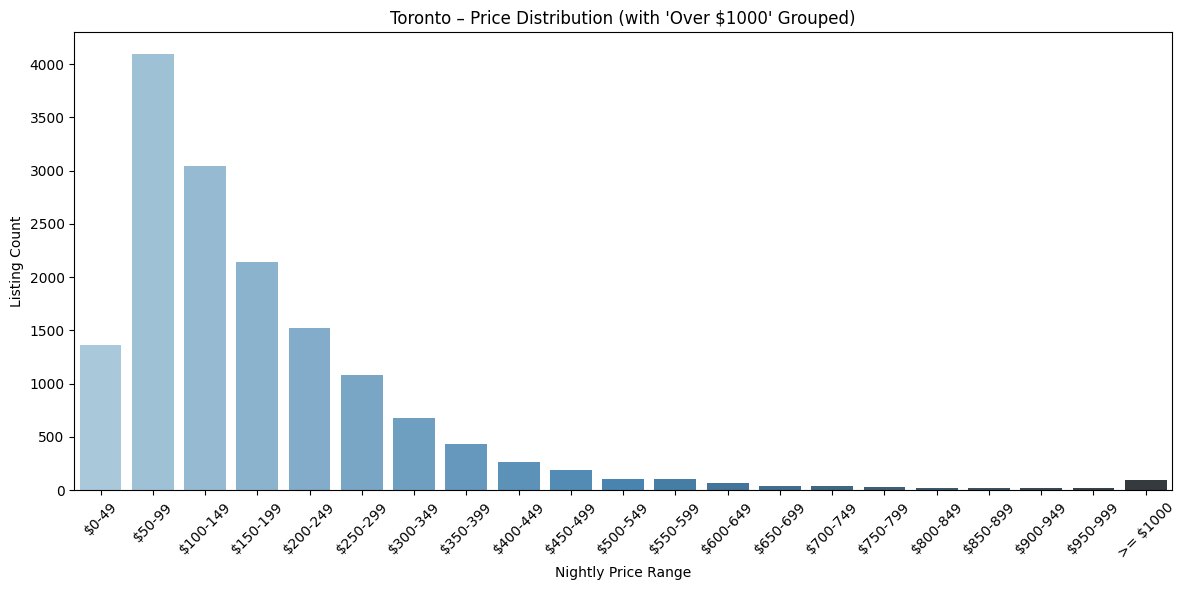

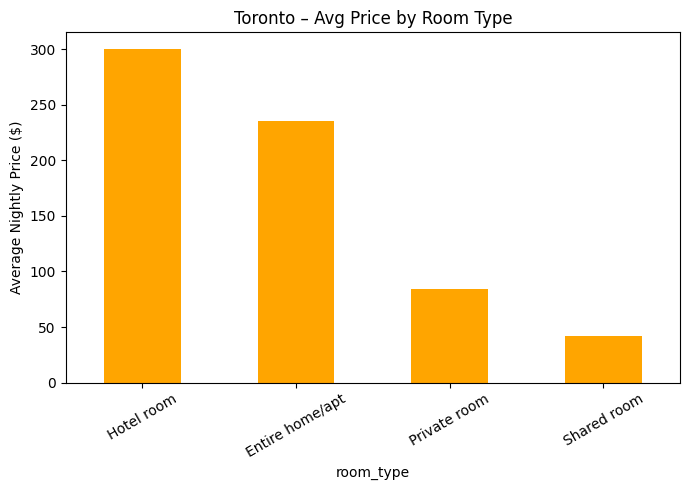

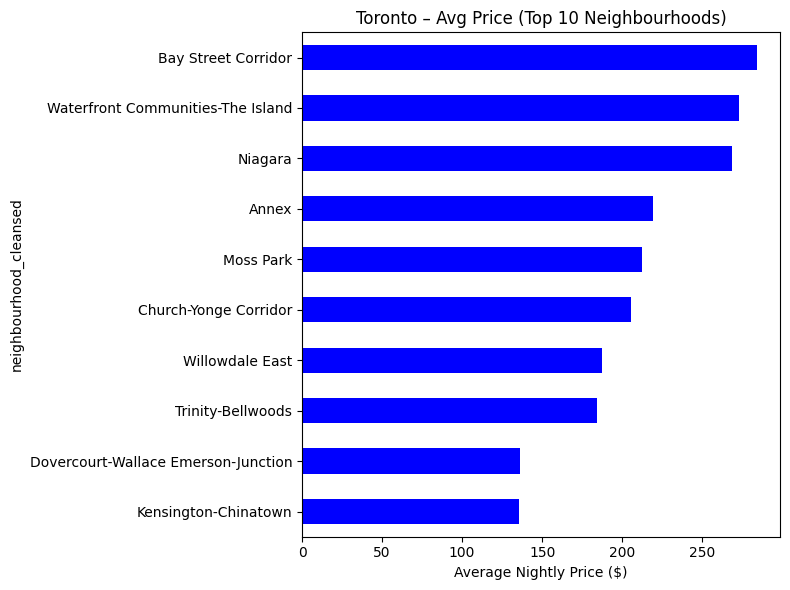

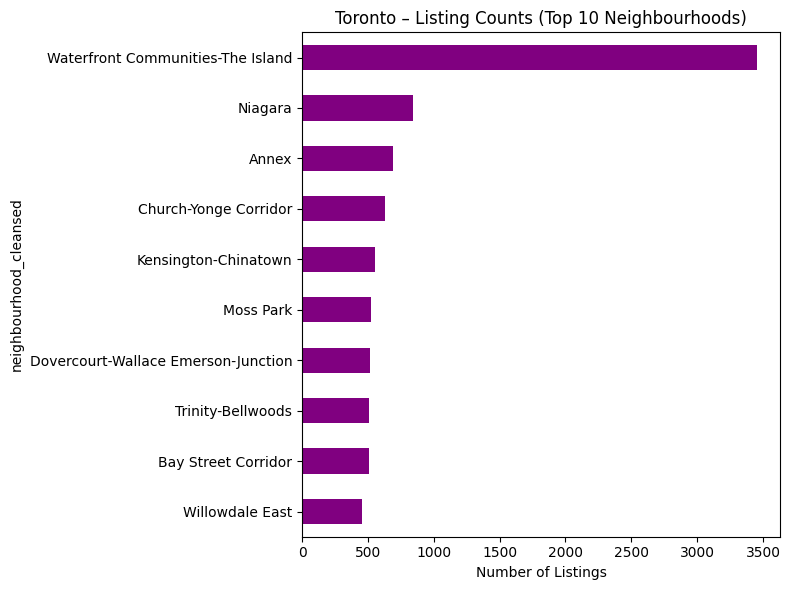

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load Google Sheets data (Toronto only)
toronto_csv_url = (
    "https://docs.google.com/spreadsheets/d/"
    "18DbatkTWogKwESjq4Hpe2pfvHOfto3DsnZwbu6o7cMM"
    "/export?format=csv&gid=1174158840"
)
tor = pd.read_csv(toronto_csv_url)

# Clean 'price' column
tor["price"] = tor["price"].replace('[\$,]', '', regex=True).astype(float)

# Helper: Save and show plots
def save_and_show(fig, filename):
    fig.savefig(f"{filename}.png", bbox_inches="tight")
    plt.show()

# Price Distribution – Group 1000+ into final bin
def plot_price_distribution_binned():
    df = tor.copy()
    df = df[df["price"] > 0]

    bin_edges = list(range(0, 1000 + 1, 50)) + [float('inf')]
    bin_labels = [f"${i}-{i+49}" for i in range(0, 1000, 50)] + [">= $1000"]
    df["price_group"] = pd.cut(df["price"], bins=bin_edges, labels=bin_labels, right=False)

    fig = plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x="price_group", palette="Blues_d")
    plt.title("Toronto – Price Distribution (with 'Over $1000' Grouped)")
    plt.xlabel("Nightly Price Range")
    plt.ylabel("Listing Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    save_and_show(fig, "price_distribution_binned")

# Average Price by Room Type
def plot_avg_price_by_room_type():
    tor_mean = tor.groupby("room_type")["price"].mean().sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(7, 5))
    tor_mean.plot(kind="bar", ax=ax, color="orange")
    ax.set_title("Toronto – Avg Price by Room Type")
    ax.set_ylabel("Average Nightly Price ($)")
    ax.tick_params(axis='x', rotation=30)
    plt.tight_layout()
    save_and_show(fig, "avg_price_by_room_type")

# Average Price by Top Neighbourhoods
def plot_avg_price_by_top_neighbourhoods():
    tor_top10 = tor["neighbourhood_cleansed"].value_counts().head(10).index
    tor_avg = tor[tor["neighbourhood_cleansed"].isin(tor_top10)]\
        .groupby("neighbourhood_cleansed")["price"].mean().sort_values(ascending=False)

    fig, ax = plt.subplots(figsize=(8, 6))
    tor_avg.plot(kind="barh", ax=ax, color='blue')
    ax.set_title("Toronto – Avg Price (Top 10 Neighbourhoods)")
    ax.set_xlabel("Average Nightly Price ($)")
    ax.invert_yaxis()
    plt.tight_layout()
    save_and_show(fig, "avg_price_by_top_neighbourhoods")

# Count of Listings per Top 10 Neighbourhoods
def plot_listing_counts_by_top_neighbourhoods():
    tor_top10 = tor["neighbourhood_cleansed"].value_counts().head(10)
    fig, ax = plt.subplots(figsize=(8, 6))
    tor_top10.sort_values(ascending=False).plot(kind="barh", ax=ax, color='purple')
    ax.set_title("Toronto – Listing Counts (Top 10 Neighbourhoods)")
    ax.set_xlabel("Number of Listings")
    ax.invert_yaxis()
    plt.tight_layout()
    save_and_show(fig, "listing_counts_by_top_neighbourhoods")

# Run All Visuals
plot_price_distribution_binned()
plot_avg_price_by_room_type()
plot_avg_price_by_top_neighbourhoods()
plot_listing_counts_by_top_neighbourhoods()


In [ ]:
#GOOD#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

#Load dataset from Google Sheets
toronto_csv_url = (
    "https://docs.google.com/spreadsheets/d/"
    "18DbatkTWogKwESjq4Hpe2pfvHOfto3DsnZwbu6o7cMM"
    "/export?format=csv&gid=1174158840"
)
tor = pd.read_csv(toronto_csv_url)

#Clean 'price' and 'bathrooms_text' fields
tor["price"] = tor["price"].replace('[\$,]', '', regex=True).astype(float)
tor["bathrooms"] = tor["bathrooms_text"].str.extract(r'(\d+\.?\d*)')[0].astype(float)

#Filter only 1-bedroom
tor_1bd = tor[tor["bedrooms"].fillna(0) == 1].copy()

#change superhost t and f to 1 and 0
tor_1bd['host_is_superhost'] = tor_1bd['host_is_superhost'].map({'t': 1, 'f': 0})
tor_1bd['host_is_superhost'] = tor_1bd['host_is_superhost'].fillna(0).astype(int)


# Select modeling features
df_model_1 = tor_1bd[[
    "price", "bathrooms","minimum_nights",
    "number_of_reviews", "review_scores_rating"
]].dropna()

# Split into X and y
X = df_model_1.drop("price", axis=1)
y = df_model_1["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_r2 = r2_score(y_test, lr_preds)

# Decision Tree Regressor
dt = DecisionTreeRegressor(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_preds))
dt_r2 = r2_score(y_test, dt_preds)

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

# XG Boost
xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_r2 = r2_score(y_test, xgb_preds)

def evaluate(name, model):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"🔹 {name}")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   R² Score: {r2:.3f}\n")

evaluate("Linear Regression", lr)
evaluate("Decision Tree (max_depth=5)", dt)
evaluate("Random Forest (max_depth=10)", rf)
evaluate("XGBoost", xgb)

🔹 Linear Regression
   RMSE: 146.42
   R² Score: -0.106

🔹 Decision Tree (max_depth=5)
   RMSE: 153.39
   R² Score: -0.214

🔹 Random Forest (max_depth=10)
   RMSE: 187.00
   R² Score: -0.805

🔹 XGBoost
   RMSE: 153.58
   R² Score: -0.217



In [ ]:
#GOOD##
####REMOVE OUTLIERS####
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Select columns including text fields
df_model_2 = tor_1bd[[
    "price", "bathrooms", "host_is_superhost",
    "number_of_reviews", "review_scores_rating"
]].dropna()


# Exclude suspiciously outliars
price_cap = df_model_2["price"].quantile(0.95)
price_low = df_model_2["price"].quantile(0.05)
df_model_2 = df_model_2[df_model_2["price"] <= price_cap]
df_model_2 = df_model_2[df_model_2["price"] > price_low]


# Final dataset

X = df_model_2.drop("price", axis=1)
y = df_model_2["price"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models
lr = LinearRegression().fit(X_train, y_train)
dt = DecisionTreeRegressor(max_depth=5, random_state=42).fit(X_train, y_train)
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42).fit(X_train, y_train)
xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42).fit(X_train, y_train)

# Evaluate
def evaluate(name, model):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"🔹 {name}")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   R² Score: {r2:.3f}\n")

evaluate("Linear Regression", lr)
evaluate("Decision Tree (max_depth=5)", dt)
evaluate("Random Forest (max_depth=10)", rf)
evaluate("XGBoost", xgb)


🔹 Linear Regression
   RMSE: 58.38
   R² Score: 0.012

🔹 Decision Tree (max_depth=5)
   RMSE: 57.15
   R² Score: 0.053

🔹 Random Forest (max_depth=10)
   RMSE: 57.82
   R² Score: 0.031

🔹 XGBoost
   RMSE: 57.36
   R² Score: 0.046



In [ ]:

#### ADD NEIGHBOURHOOD_CLEANSED, ROOM TYPE ####
# Select modeling features
df_model_3 = tor_1bd[[
    "price", "bathrooms", "host_is_superhost", "accommodates", "minimum_nights", "room_type",
    "neighbourhood_cleansed", "number_of_reviews", "review_scores_rating"
]].dropna()

# Exclude suspiciously outliars
price_cap = df_model_3["price"].quantile(0.95)
price_low = df_model_3["price"].quantile(0.05)
df_model_3 = df_model_3[df_model_3["price"] <= price_cap]
df_model_3 = df_model_3[df_model_3["price"] > price_low]


# One-hot encode 'neighbourhood_cleansed'
df_model_3 = pd.get_dummies(df_model_3, columns=["neighbourhood_cleansed", "accommodates", "room_type"], drop_first=True)

# Split into X and y
X = df_model_3.drop("price", axis=1)
y = df_model_3["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_r2 = r2_score(y_test, lr_preds)

# Decision Tree Regressor
dt = DecisionTreeRegressor(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_preds))
dt_r2 = r2_score(y_test, dt_preds)

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

# XG Boost
xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_r2 = r2_score(y_test, xgb_preds)


# Print results
print("🔹 Linear Regression")
print(f"   RMSE: {lr_rmse:.2f}")
print(f"   R² Score: {lr_r2:.3f}\n")

print("🔹 Decision Tree (max_depth=5)")
print(f"   RMSE: {dt_rmse:.2f}")
print(f"   R² Score: {dt_r2:.3f}\n")

print(f"🔹 Random Forest (max_depth=10)")
print(f"  RMSE: {rf_rmse:.2f}")
print(f"  R² Score: {rf_r2:.3f}\n")

print("🔹 XGBoost Regressor")
print(f"   RMSE: {xgb_rmse:.2f}")
print(f"   R² Score: {xgb_r2:.3f}")


🔹 Linear Regression
   RMSE: 39.71
   R² Score: 0.543

🔹 Decision Tree (max_depth=5)
   RMSE: 40.75
   R² Score: 0.519

🔹 Random Forest (max_depth=10)
  RMSE: 38.29
  R² Score: 0.575

🔹 XGBoost Regressor
   RMSE: 37.13
   R² Score: 0.600


In [ ]:
#GOOD#
####ADD TF-IDF####
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Select columns including text fields
df_model_4 = tor_1bd[[
    "price", "bathrooms", "host_is_superhost", "accommodates", "minimum_nights", "room_type",
    "neighbourhood_cleansed", "number_of_reviews", "review_scores_rating",
    "name", "description", "neighborhood_overview"
]].dropna()

# Exclude suspiciously outliars
price_cap = df_model_4["price"].quantile(0.95)
price_low = df_model_4["price"].quantile(0.05)
df_model_4 = df_model_4[df_model_4["price"] <= price_cap]
df_model_4 = df_model_4[df_model_4["price"] > price_low]


# One-hot encoding
df_model_4 = pd.get_dummies(df_model_4, columns=["neighbourhood_cleansed", "accommodates", "room_type"], drop_first=True)

# TF-IDF: Combine all 3 text fields
combined_text = (
    df_model_4["name"].fillna('') + " " +
    df_model_4["description"].fillna('') + " " +
    df_model_4["neighborhood_overview"].fillna('')
)

tfidf = TfidfVectorizer(max_features=200, stop_words='english')
tfidf_matrix = tfidf.fit_transform(combined_text)
text_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out(), index=df_model_4.index)

# Final dataset
df_model_4 = df_model_4.drop(columns=["name", "description", "neighborhood_overview"])
X = pd.concat([df_model_4.drop("price", axis=1), text_matrix], axis=1)
y = df_model_4["price"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models
lr = LinearRegression().fit(X_train, y_train)
dt = DecisionTreeRegressor(max_depth=5, random_state=42).fit(X_train, y_train)
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42).fit(X_train, y_train)
xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42).fit(X_train, y_train)

# Evaluate
def evaluate(name, model):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"🔹 {name}")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   R² Score: {r2:.3f}\n")

evaluate("Linear Regression", lr)
evaluate("Decision Tree (max_depth=5)", dt)
evaluate("Random Forest (max_depth=10)", rf)
evaluate("XGBoost", xgb)

#Here are the top TF-IDF features and their importances in your XGBoost model.
#As you can see, all the values are zero—this means that the model is not actually using any of the text features to make predictions.
#That's why modifying name, description, or neighborhood_overview in the input had no/negative effect on predicted price.
#The model likely found stronger, more predictive patterns in the structured features like bathrooms, superhost, or number_of_reviews, and is ignoring the text features.
#TF-IDF produces sparse, shallow representations—often useful only when there's rich, varying, and meaningful language. Airbnb listing text might be too generic or noisy.

🔹 Linear Regression
   RMSE: 41.38
   R² Score: 0.496

🔹 Decision Tree (max_depth=5)
   RMSE: 41.14
   R² Score: 0.502

🔹 Random Forest (max_depth=10)
   RMSE: 37.67
   R² Score: 0.582

🔹 XGBoost
   RMSE: 37.10
   R² Score: 0.595



In [ ]:
#### Retrain with non- TF-IDF because TF-IDF modeling was reducing the accuracy ####
X = df_model_3.drop("price", axis=1)
y = df_model_3["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_r2 = r2_score(y_test, lr_preds)

# Decision Tree Regressor
dt = DecisionTreeRegressor(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_preds))
dt_r2 = r2_score(y_test, dt_preds)

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

# XG Boost
xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_r2 = r2_score(y_test, xgb_preds)


# Print results
print("🔹 Linear Regression")
print(f"   RMSE: {lr_rmse:.2f}")
print(f"   R² Score: {lr_r2:.3f}\n")

print("🔹 Decision Tree (max_depth=5)")
print(f"   RMSE: {dt_rmse:.2f}")
print(f"   R² Score: {dt_r2:.3f}\n")

print(f"🔹 Random Forest (max_depth=10)")
print(f"  RMSE: {rf_rmse:.2f}")
print(f"  R² Score: {rf_r2:.3f}\n")

print("🔹 XGBoost Regressor")
print(f"   RMSE: {xgb_rmse:.2f}")
print(f"   R² Score: {xgb_r2:.3f}")

🔹 Linear Regression
   RMSE: 40.58
   R² Score: 0.551

🔹 Decision Tree (max_depth=5)
   RMSE: 40.98
   R² Score: 0.542

🔹 Random Forest (max_depth=10)
  RMSE: 39.00
  R² Score: 0.585

🔹 XGBoost Regressor
   RMSE: 37.68
   R² Score: 0.612


🔍 Top 10 Most Important Features:


,Feature,Importance
152,room_type_Private room,0.307191
126,neighbourhood_cleansed_Waterfront Communities-...,0.063505
91,neighbourhood_cleansed_Niagara,0.035471
2,minimum_nights,0.034738
7,neighbourhood_cleansed_Annex,0.029079
10,neighbourhood_cleansed_Bay Street Corridor,0.027555
83,neighbourhood_cleansed_Moss Park,0.017204
27,neighbourhood_cleansed_Church-Yonge Corridor,0.016687
88,neighbourhood_cleansed_New Toronto,0.014542
146,accommodates_4,0.014371


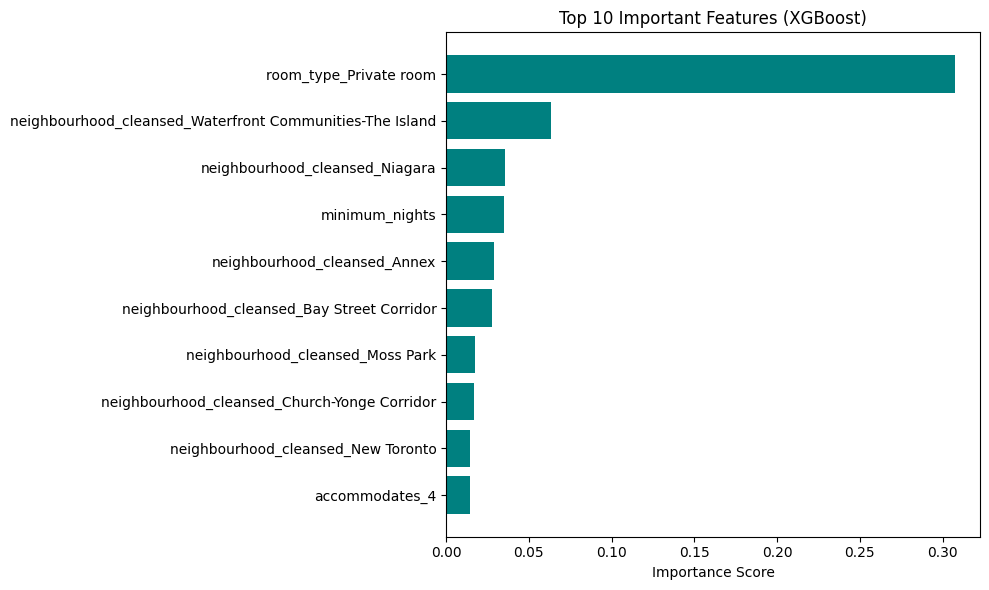

In [ ]:

# Get feature importances
importances = xgb.feature_importances_

# Match with feature names
feature_names = X_train.columns
importance_xgb = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

# Sort by importance
importance_xgb = importance_xgb.sort_values(by="Importance", ascending=False)

# Display top 10
print("🔍 Top 10 Most Important Features:")
display(importance_xgb.head(10))

# Plot it
plt.figure(figsize=(10, 6))
plt.barh(importance_xgb.head(10)["Feature"], importance_xgb.head(10)["Importance"], color="teal")
plt.xlabel("Importance Score")
plt.title("Top 10 Important Features (XGBoost)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
import joblib
import os

# Create directory to save files (optional)
os.makedirs("streamlit_assets", exist_ok=True)

# Save XGBoost model
joblib.dump(xgb, "streamlit_assets/xgb_model_toronto.joblib")

# Save feature columns
joblib.dump(X.columns.tolist(), "streamlit_assets/feature_columns.joblib")

# Save dropdown values
joblib.dump(sorted(tor_1bd["neighbourhood_cleansed"].dropna().unique().tolist()), "streamlit_assets/neighborhoods.joblib")
joblib.dump(sorted(tor_1bd["accommodates"].dropna().astype(int).unique().tolist()), "streamlit_assets/accommodates.joblib")
joblib.dump(sorted(tor_1bd["room_type"].dropna().unique().tolist()), "streamlit_assets/room_type.joblib")

avg_values = {
    "bathrooms": df_model_4["bathrooms"].mean(),
    "minimum_nights": df_model_4["minimum_nights"].mean(),
    "review_scores_rating": df_model_4["review_scores_rating"].mean(),
    "number_of_reviews": df_model_4["number_of_reviews"].mean()
}

joblib.dump(avg_values, "streamlit_assets/average_values.joblib")

print("✅ All files saved to 'streamlit_assets' folder.")

from google.colab import files
import glob

# Download all saved assets
for file in glob.glob("streamlit_assets/*.joblib"):
    files.download(file)



✅ All files saved to 'streamlit_assets' folder.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>